In this notebook I'm going to try a random forest.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
from pre_processing import get_training_data, get_test_data, get_meta_data, number_to_name

In [4]:
train_X, train_y = get_training_data()
test_X, test_y = get_test_data()

First, let's just see what happens if we pick a fairly stupid model. We'll use a maximum depth of 20 and just 4 estimators. 

In [18]:
naive_forest = RandomForestClassifier(n_estimators=4, criterion='gini', 
                                     random_state=159, max_depth = 20)
naive_forest.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=159, verbose=0, warm_start=False)

In [19]:
y_test_pred = naive_forest.predict(test_X)

In [20]:
accuracy_score(test_y, y_test_pred)

0.29570000000000002

In [21]:
y_train_pred = naive_forest.predict(train_X)
accuracy_score(train_y, y_train_pred)

0.89666000000000001

### Why So Much Overfitting? 

Wow, that's a whole lot of overfitting. Let's take a peek inside the model to see what it's up to. 

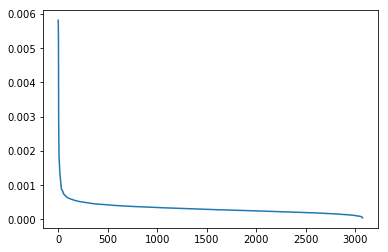

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

naive_feature_importances = sorted(naive_forest.feature_importances_, reverse=True)
plt.plot(np.arange(1, 3073), naive_feature_importances)

Interesting. Looks like an exponential distribution. What if we tried log-scaling the y-axis? I would expect a straight, downward-sloping line then. 

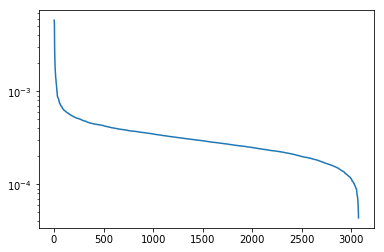

In [24]:
plt.plot(np.arange(1, 3073), naive_feature_importances)
plt.semilogy();

Hmm. Looks like I was correct for values in the middle of the range, but totally wrong for the top and bottom 50 or so values. What's going on there? 

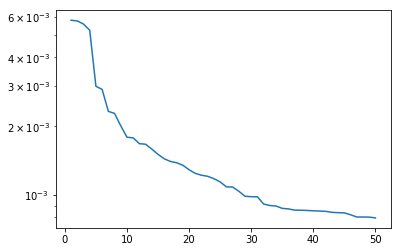

In [31]:
plt.plot(np.arange(1, 51), naive_feature_importances[:50])
plt.semilogy();

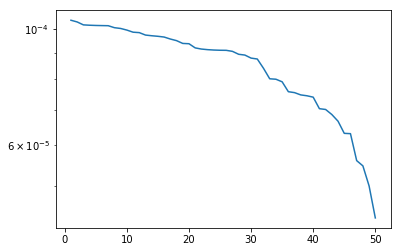

In [32]:
plt.plot(np.arange(1, 51), naive_feature_importances[-50:])
plt.semilogy();

Even afte a log-scaling, it looks like the curve is almost parabolic. Lesson: The random forest really values its top 10-20 features, and really hates its bottom 20 or so. The middle 3,000 or so are relatively equally weighted.

### Attempt 1: Grid Search on max_features

What if we tried introducing more randomness in the feature selection? Recall that if a dataset has $n$ features, a random forest randomly selects a sample of $m$ of those features, and then picks the best split amongst those $m$ options. By default, scikit-learn has $m = \sqrt{n}$. What if we tried smaller versions of $m$? 

This calls for a grid search on $m$. Because we want to test this hypothesis against the previous result, we'll hold all other model hyperparameters constant - in our case, this means using the Gini impurity metric, using $4$ estimators, and a maximum tree depth of $20$. 

In [36]:
np.sqrt(3072)/3072

0.018042195912175804

Given that we have exactly $3072$ features for each image, our current $m$ is at approximately $1.8\%$ of the features. Since we want to introduce more randomness, we'll consider much smaller $m$ - at a log-spacing from $10^{-8}$ to $10^{-2}$.

In [38]:
#declare a grid searcher object with forest_hyperparams as a dictionary of possible hyperparameters 
forest_hyperparams = {'max_features': np.logspace(-8, -2, num=10)}
generic_model = RandomForestClassifier(criterion='gini', n_estimators=4, max_depth=20, random_state=159)   
grid_searcher = GridSearchCV(generic_model, forest_hyperparams, return_train_score=True)

In [39]:
grid_searcher.fit(train_X, train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=159, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': array([  1.00000e-08,   4.64159e-08,   2.15443e-07,   1.00000e-06,
         4.64159e-06,   2.15443e-05,   1.00000e-04,   4.64159e-04,
         2.15443e-03,   1.00000e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
grid_searcher.best_score_

0.28167999999999999

In [42]:
grid_searcher.best_params_

{'max_features': 0.01}

Wow! 10 minutes of grid searching later and we got a worse result! It turns out that the maximum value of $m$, $m = 0.01$, had the best result. And this performed worse than $m \approx 0.018$, which was our naive implementation.

In [ ]:
plt.figure(figsize=(12, 8))
# mse_mean = np.mean(predictor.mse_path_, axis=1)
# mse_max = np.max(predictor.mse_path_, axis=1)
# mse_min = np.min(predictor.mse_path_, axis=1)

# # mse_std_dev = np.std(predictor.mse_path_, axis=1)
# alphas = predictor.alphas_
# plt.plot(alphas, mse_mean, c='blue', label='Average')
# plt.plot(alphas, mse_max, 'b--', label='Max Fold')
# plt.plot(alphas, mse_min, 'b--', label='Min Fold')
# plt.semilogx()
# plt.fill_between(alphas, mse_min, mse_max, alpha=0.2)
# plt.title(r'Validation Error of LASSO with respect to $\alpha$')
# plt.xlabel(r'$\alpha$ Value')
# plt.ylabel('Validation Error')
# plt.savefig('figures/lasso_cv_alphas_error.png')
# plt.legend()
# plt.show();

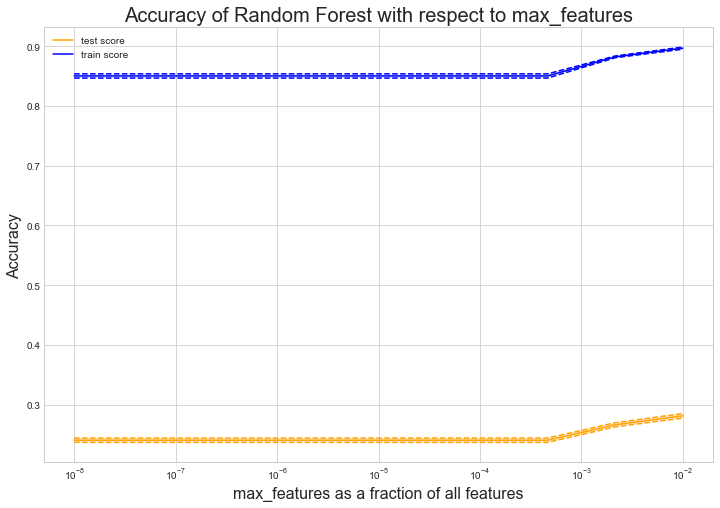

In [51]:
m_vals = np.logspace(-8, -2, num=10)
import seaborn as sns
sns.set_style('whitegrid')

plt.figure(figsize=(12, 8))
plt.plot(m_vals, grid_searcher.cv_results_['mean_test_score'], c='orange', label='test score')
plt.plot(m_vals, grid_searcher.cv_results_['mean_test_score'] - 2 * grid_searcher.cv_results_['std_test_score'], 
                 'b--', c='orange')
plt.plot(m_vals, grid_searcher.cv_results_['mean_test_score'] + 2 * grid_searcher.cv_results_['std_test_score'], 
                 'b--', c='orange')

plt.plot(m_vals, grid_searcher.cv_results_['mean_train_score'], c='blue', label='train score')
plt.plot(m_vals, grid_searcher.cv_results_['mean_train_score'] - 2 * grid_searcher.cv_results_['std_train_score'], 
                 'b--', c='blue')
plt.plot(m_vals, grid_searcher.cv_results_['mean_train_score'] + 2 * grid_searcher.cv_results_['std_train_score'], 
                 'b--', c='blue')

plt.fill_between(m_vals, grid_searcher.cv_results_['mean_train_score'] - 2 * grid_searcher.cv_results_['std_train_score'],
                 grid_searcher.cv_results_['mean_train_score'] + 2 * grid_searcher.cv_results_['std_train_score'],
                 alpha=0.2)

plt.fill_between(m_vals, grid_searcher.cv_results_['mean_test_score'] - 2 * grid_searcher.cv_results_['std_test_score'],
                 grid_searcher.cv_results_['mean_test_score'] + 2 * grid_searcher.cv_results_['std_test_score'],
                 alpha=0.2)
plt.semilogx();
plt.legend()
plt.xlabel('max_features as a fraction of all features', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy of Random Forest with respect to max_features', fontsize=20)